In [1]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("daily-minimum-temperatures-in-me.csv")

In [3]:
data.head()

,Date,Min_temp
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      3650 non-null   object 
 1   Min_temp  3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [5]:
data['Min_temp'] = data['Min_temp'].apply(lambda x: float(x))

In [6]:
data

,Date,Min_temp
0,1/1/1981,20.7
1,1/2/1981,17.9
2,1/3/1981,18.8
3,1/4/1981,14.6
4,1/5/1981,15.8
...,...,...
3645,12/27/1990,14.0
3646,12/28/1990,13.6
3647,12/29/1990,13.5
3648,12/30/1990,15.7


In [7]:
series = data['Min_temp']

In [8]:
seq = series.copy()

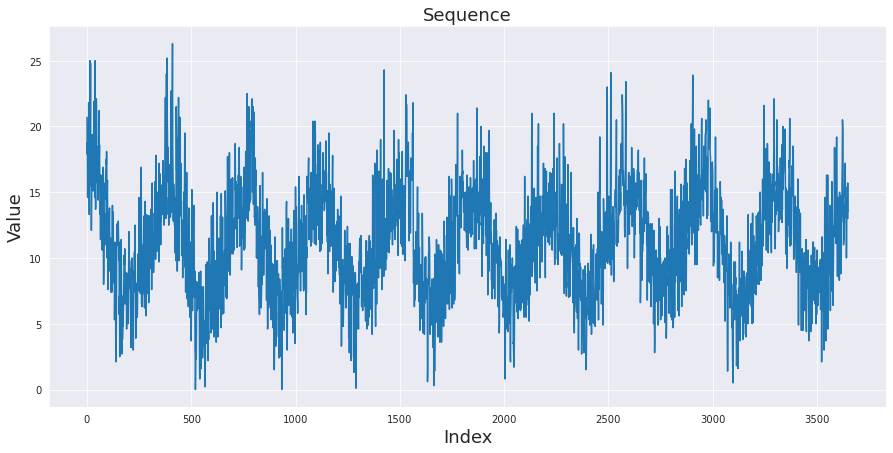

In [9]:
plt.figure(figsize=(15,7))
plt.title("Sequence", fontsize = 18)
plt.xlabel("Index", fontsize = 18)
plt.ylabel("Value", fontsize = 18)
plt.plot(seq)
plt.show()

In [10]:
scaler = MinMaxScaler(feature_range=(-1,1))
X =scaler.fit_transform(seq.values.reshape(-1,1))

In [11]:
x_train = X[2500:-100]
y = X[-100:]

In [12]:
input_seq_len = 60
output_seq_len = 20
n_in_features = 1
n_out_features = 1
batch_size = 10

In [13]:
def generate_train_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

In [14]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [15]:
def run_model(model,batches,epochs,batch_size):

    for _ in range(batches):

        input_seq, output_seq = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.1, 
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [17]:
a=[i for i in [2,2]]

[2, 2]

In [19]:
layers=[60,60]
lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]


In [20]:
lstm_cells

In [21]:

input_seq_len = 60
output_seq_len = 20
n_in_features = 1
n_out_features = 1
batch_size = 10



# encoder_inputs = Input(shape=(None, n_in_features))
# lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]

# encoder = RNN(lstm_cells, return_state=True)
# encoder_outputs_and_states = encoder(encoder_inputs)
# encoder_states = encoder_outputs_and_states[1:]

# decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
# decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

# decoder_outputs_and_states = decoder_lstm(decoder_inputs,
#                                       initial_state=encoder_states)
# decoder_outputs = decoder_outputs_and_states[0]

# decoder_dense = Dense(n_out_features) 
# decoder_outputs = decoder_dense(decoder_outputs)

# model = Model([encoder_inputs,decoder_inputs], decoder_outputs)



def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model